In [20]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [147]:
datos = []
with open('ATLAS_events_v0.json', 'r', encoding='utf-8') as f:
    for item in ijson.items(f, 'item'):
        datos.append(item)
        if len(datos) >= 12500:
            break

In [164]:
exotic_signal_datos = []
with open('jets_data_exotic_signals.json', 'r', encoding='utf-8') as f:
    for item in ijson.items(f, 'item'):
        exotic_signal_datos.append(item)
        if len(exotic_signal_datos) >= 12500:
            break

nominal_higgs_datos = []
with open('jets_data_higgs_nominal_samples.json', 'r', encoding='utf-8') as f:
    for item in ijson.items(f, 'item'):
        nominal_higgs_datos.append(item)
        if len(nominal_higgs_datos) >= 12500:
            break

In [165]:
from sklearn.model_selection import train_test_split

datos = np.array(datos)

# Dividir en train y test (80% - 20%)
X_train, X_test = train_test_split(
    datos, 
    test_size=0.2,      # 20% para test
    random_state=42,    # Semilla para reproducibilidad
    shuffle=True        # Mezclar datos antes de dividir
)

exotic_signal = exotic_signal_datos[:2500]
nominal_higgs = nominal_higgs_datos[:2500]

In [167]:
def decimal_to_float(data):
    if isinstance(data, Decimal):
        return float(data)
    elif isinstance(data, dict):
        return {key: decimal_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [decimal_to_float(item) for item in data]
    else:
        return data  # Para int, str, etc.

def filtrar_jets_con_padding(datos, max_jets=4):
    eventos_con_jets = []

    for evento in datos:
        # Buscar la clave 'jets' (case insensitive)
        jets = evento.get('jets') or evento.get('Jets') or evento.get('JETS')

        if jets and len(jets) > 0:
            # Filtrar jets que tengan pt, eta y phi
            jets_filtrados = sorted(
                (
                    {
                        'pt': float(jet['pt']),
                        'eta': float(jet['eta']),
                        'phi': float(jet['phi'])
                    }
                    for jet in jets
                    if all(k in jet for k in ['pt', 'eta', 'phi'])
                ),
                key=lambda x: x['pt'],
                reverse=True
            )

            # Tomar hasta max_jets jets reales
            jets_finales = jets_filtrados[:max_jets]

            # Padding: agregar jets vacíos si hay menos de max_jets
            while len(jets_finales) < max_jets:
                jets_finales.append({'pt': 0.0, 'eta': 0.0, 'phi': 0.0})

            # Guardar el evento con los jets preparados
            eventos_con_jets.append({'Jets': jets_finales})

    return eventos_con_jets



def encontrar_maximos(datos_filtrados):
    max_pt = -float('inf')
    max_eta = -float('inf')
    max_phi = -float('inf')

    for evento in datos_filtrados:
        if 'Jets' in evento:
            for jet in evento['Jets']:
                max_pt = max(max_pt, jet['pt'])
                max_eta = max(max_eta, jet['eta'])
                max_phi = max(max_phi, jet['phi'])

    return max_pt, max_eta, max_phi




In [169]:
def filtrar_jets_con_padding_v2(datos, max_jets=4):
    eventos_con_jets = []

    for evento in datos:
        # Buscar la clave 'jets' (case insensitive)

        if evento and len(evento) > 0:
            # Filtrar jets que tengan pt, eta y phi
            jets_filtrados = sorted(
                (
                    {
                        'pt': float(jet['pt']),
                        'eta': float(jet['eta']),
                        'phi': float(jet['phi'])
                    }
                    for jet in evento
                    if all(k in jet for k in ['pt', 'eta', 'phi'])
                ),
                key=lambda x: x['pt'],
                reverse=True
            )

            # Tomar hasta max_jets jets reales
            jets_finales = jets_filtrados[:max_jets]

            # Padding: agregar jets vacíos si hay menos de max_jets
            while len(jets_finales) < max_jets:
                jets_finales.append({'pt': 0.0, 'eta': 0.0, 'phi': 0.0})

            # Guardar el evento con los jets preparados
            eventos_con_jets.append({'Jets': jets_finales})

    return eventos_con_jets

In [171]:
filtered_data_train = filtrar_jets_con_padding(X_train)
filtered_data_test = filtrar_jets_con_padding(X_test)
filtered_data_exotic_test = filtrar_jets_con_padding_v2(exotic_signal)
filtered_data_higgs_test = filtrar_jets_con_padding_v2(nominal_higgs)

filtered_data_float_train = [decimal_to_float(event) for event in filtered_data_train]
filtered_data_float_test = [decimal_to_float(event) for event in filtered_data_test]
filtered_data_exotic_test = [decimal_to_float(event) for event in filtered_data_exotic_test]
filtered_data_higgs_test = [decimal_to_float(event) for event in filtered_data_higgs_test]

> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}


In [151]:
#Declaro la funcion 'f = f(w)' que tiene pinta que va a ser ese hiperparámtro que vamos a tener que ir mejorando

def f(w):
  return 1 + (2* np.pi / (1 + np.exp(-w)))

def phi_circuit(w, Phi, Phi_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Phi - Phi_jet)

def theta_circuit(w, Theta, Theta_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Theta - Theta_jet)


In [152]:
num_jets_train = len(filtered_data_float_train)
num_jets_test = len(filtered_data_float_test)
print("Numbero de evetos de entrenamiento: ", num_jets_train)
print("Numbero de evetos de test: ", num_jets_test)

Numbero de evetos de entrenamiento:  9985
Numbero de evetos de test:  2494


### ⚠️⚠️ **Funciones que cree SOLO para mostrar como se visualizarian los jets en la esfera de bloch** (para un ejemplo pasado de 10 eventos solo )
Puede ser útil para visualizar cosas y orientarnos un poco. Si ves nombres de variables que no coinciden es qprque fuí evolucionando el resto del código y esto quedó ahí estancado, para no perder las imágenes.

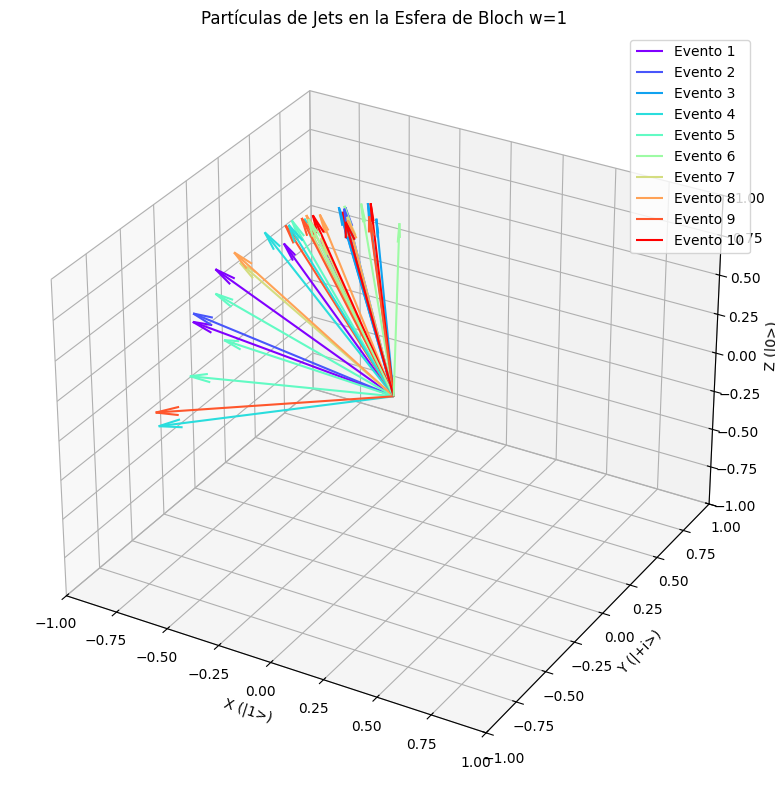

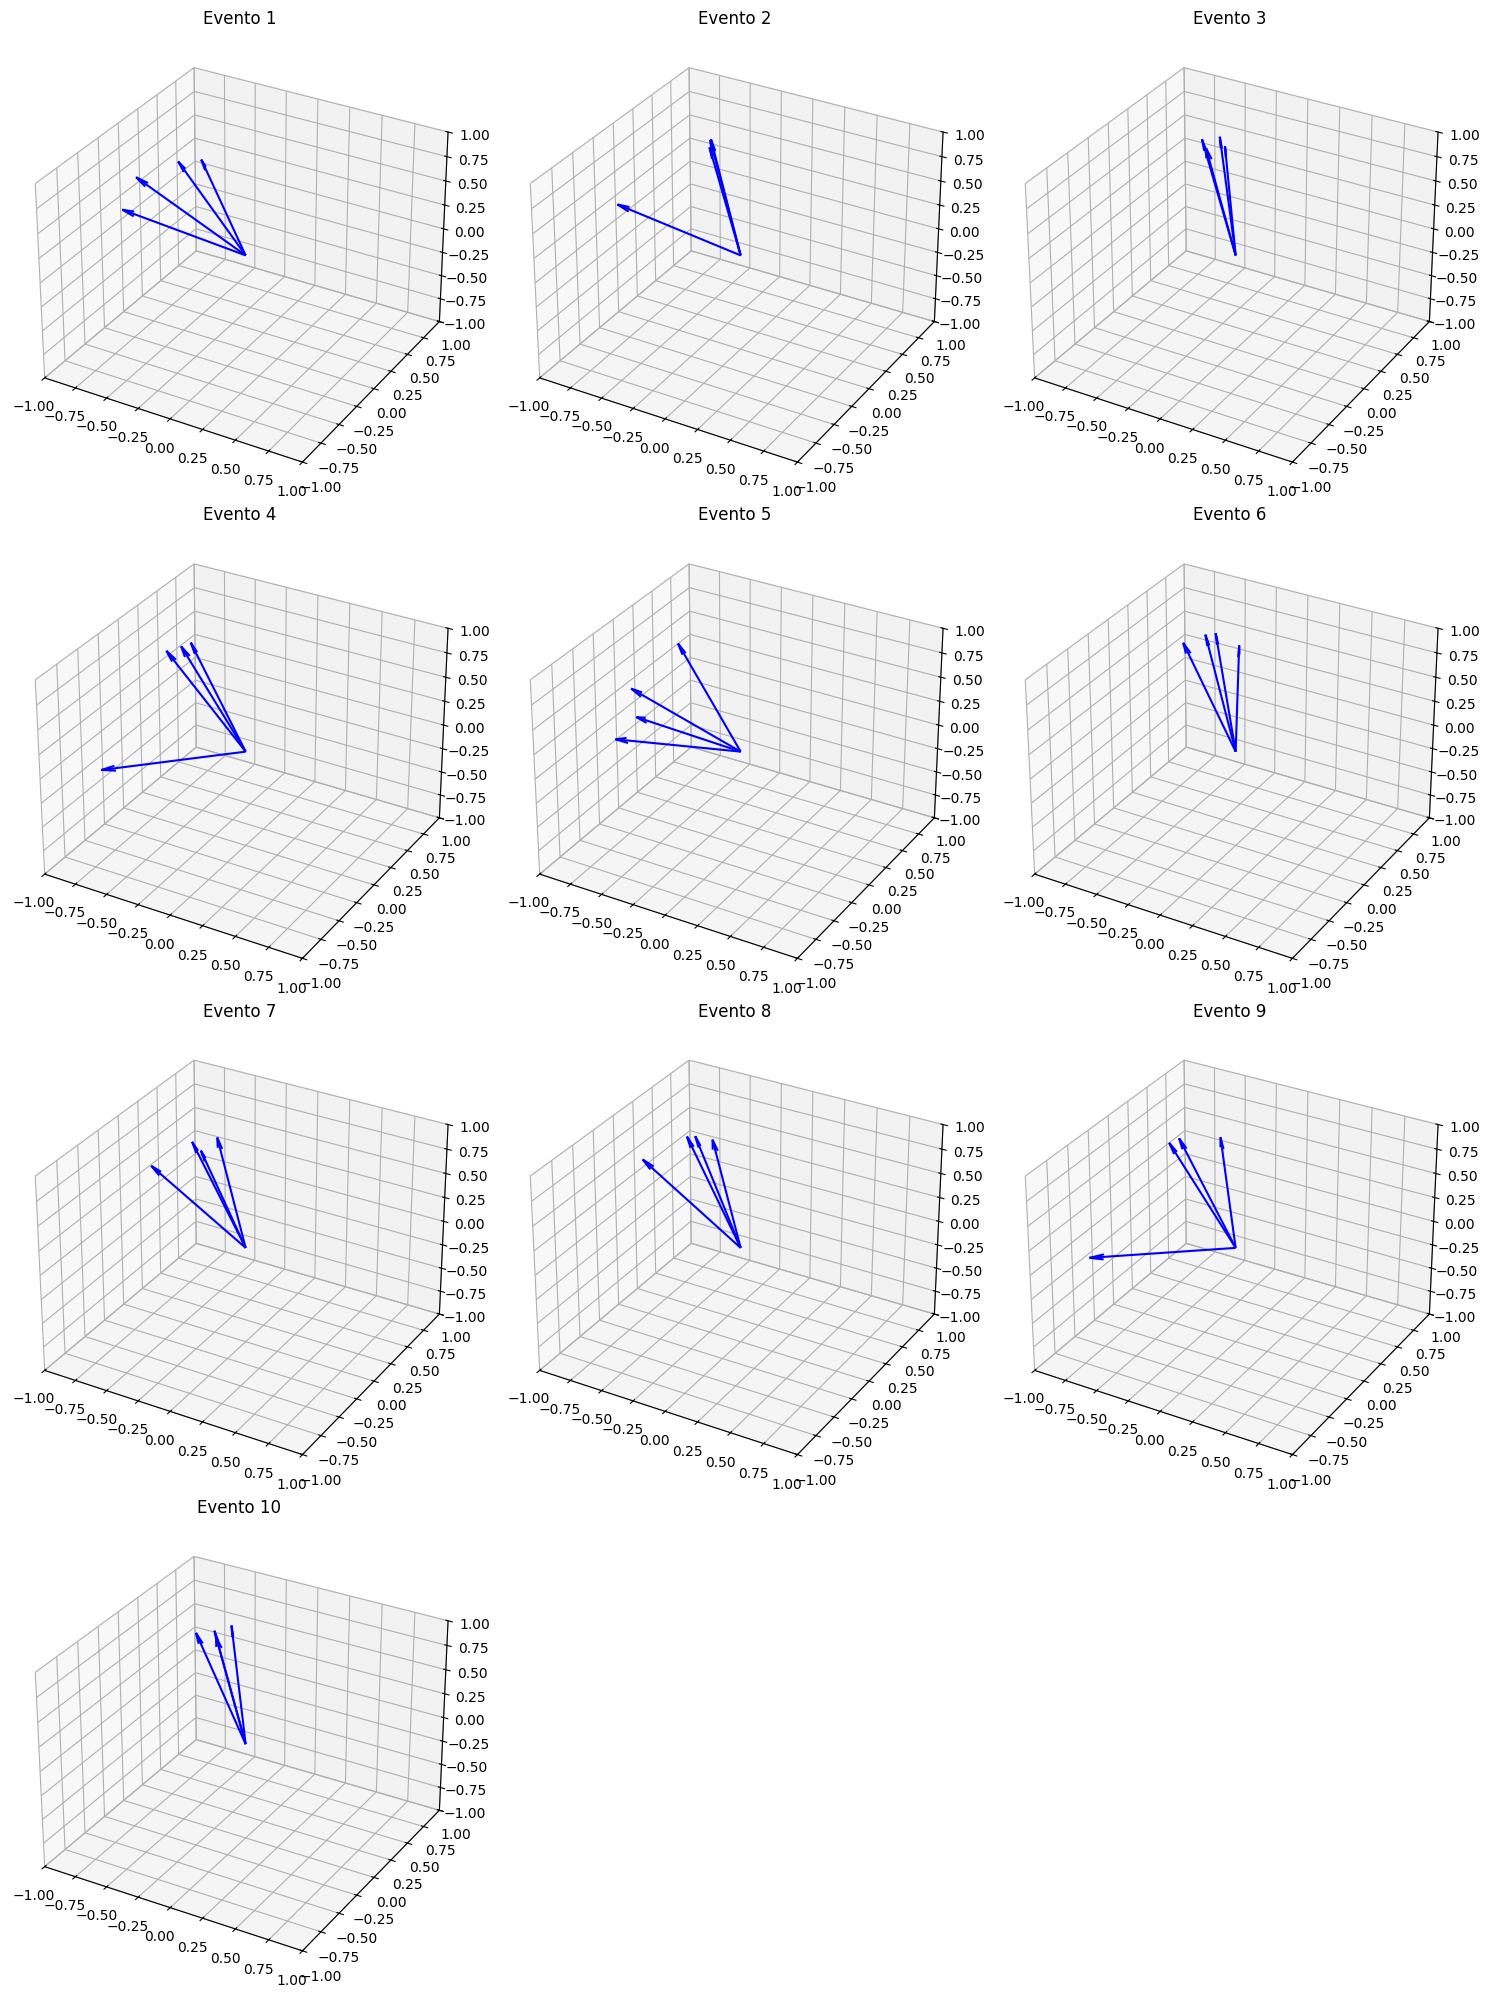

In [158]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def plot_jets_on_bloch(jets_data, num_particles=10):
    # Configurar colores distintos para cada jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets_data)))

    # Crear figura 3D para la esfera de Bloch
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        # Tomar las primeras 'num_particles' partículas del jet
        particles = jet['Jets'][:num_particles]

        for part_idx, particle in enumerate(particles):
            # Calcular theta y phi según el esquema 1P1Q
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            # Crear circuito cuántico para esta partícula
            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            # Obtener el estado cuántico
            state = Statevector.from_instruction(qc)
            bloch = state.data

            # Convertir a coordenadas cartesianas
            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            # Graficar el vector con color específico para este jet
            ax.quiver(0, 0, 0, x, y, z,
                      color=colors[jet_idx],
                      arrow_length_ratio=0.1,
                      label=f'Evento {jet_idx+1}' if part_idx == 0 else "")

    # Configuración del gráfico
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X (|1>)')
    ax.set_ylabel('Y (|+i>)')
    ax.set_zlabel('Z (|0>)')
    ax.set_title('Partículas de Jets en la Esfera de Bloch w=1')

    # Mostrar leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Función alternativa para mostrar cada jet en una esfera separada
def plot_jets_separate_bloch(jets_data, num_particles=10):
    num_jets = len(jets_data)
    cols = 3  # Número de columnas en el grid
    rows = (num_jets + cols - 1) // cols

    fig = plt.figure(figsize=(cols*5, rows*5))

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        ax = fig.add_subplot(rows, cols, jet_idx+1, projection='3d')
        particles = jet['Jets'][:num_particles]

        for particle in particles:
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            state = Statevector.from_instruction(qc)
            bloch = state.data

            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            ax.quiver(0, 0, 0, x, y, z,
                      color='blue',
                      arrow_length_ratio=0.1)

        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f'Evento {jet_idx+1}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_jets_on_bloch(filtered_data_float_train[:10])  # Todos los jets en una esfera
plot_jets_separate_bloch(filtered_data_float_train[:10])  # Jets en esferas separadas

---
---
---
---

# **Código del paper**

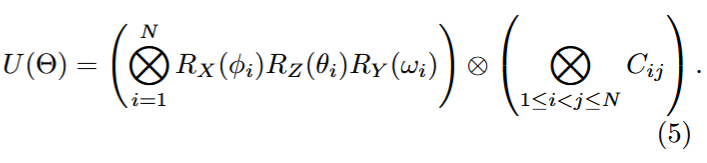

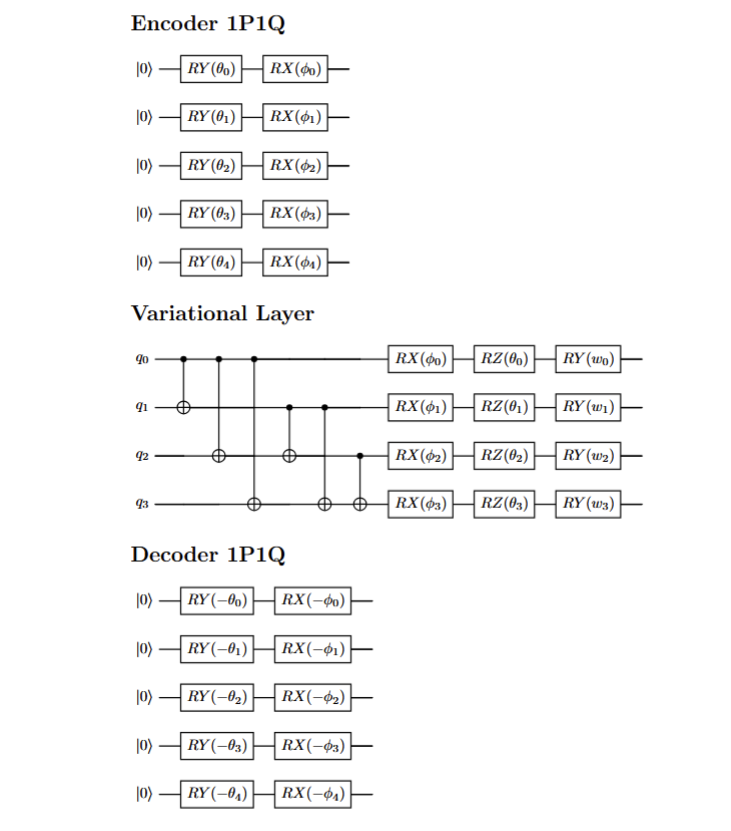

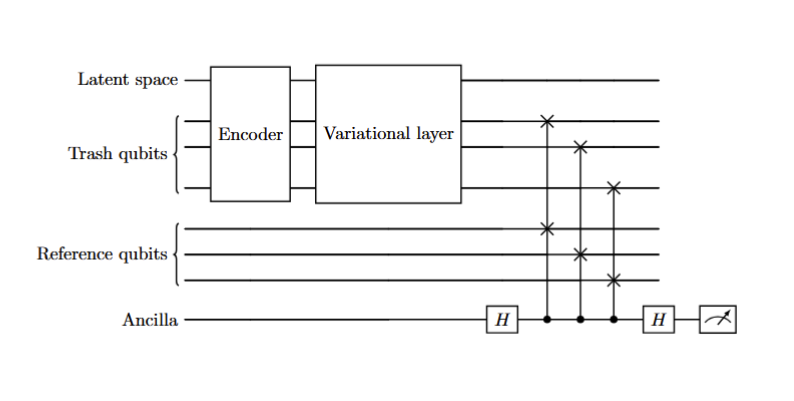

In [174]:

# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)  


latent_wire = 0                    # Qubit latente (no se toca)
trash_wires = wires[1:num_particles]  # Qubits trash [1, 2, 3]
ref_wires = wires[num_particles:-1]   # Qubits referencia [4, 5, 6] (se inicializan a |0>)


# --- Codificación 1P1Q ---
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * pt / pt_jet * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * pt / pt_jet * (eta - eta_jet)

# --- Encoder y decoder 1P1Q ---
def encode_1p1q(jets, w, pt_jet, eta_jet, phi_jet):
    for i in range(num_particles):
        theta = theta_circuit(w, jets[i]['eta'], eta_jet, jets[i]['pt'], pt_jet)
        phi = phi_circuit(w, jets[i]['phi'], phi_jet, jets[i]['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)

def decode_1p1q(jets, w, pt_jet, eta_jet, phi_jet):   #Esto en principio no nos hace falta
    for i in reversed(range(num_particles)):
        theta = theta_circuit(w, jets[i]['eta'], eta_jet, jets[i]['pt'], pt_jet)
        phi = phi_circuit(w, jets[i]['phi'], phi_jet, jets[i]['pt'], pt_jet)
        qml.RX(-phi, wires=i)
        qml.RY(-theta, wires=i)

# --- Capa variacional (Ecuación 5) ---
def variational_layer(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):  # Itera sobre cada capa
        # 1. Entrelazamiento (misma estructura por capa)
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.CNOT(wires=[i, j])
        
        # 2. Rotaciones (parámetros específicos por capa y qubit)
        for i in range(num_particles):
            qml.RX(phi_i[layer, i], wires=i)  # phi_i[layer, i] es el parámetro para la capa `layer` y qubit `i`
            qml.RZ(theta_i[layer, i], wires=i)
            qml.RY(w_i[layer, i], wires=i)

# --- QAE Circuit ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit(jets, w, pt_jet, eta_jet, phi_jet, theta_i, phi_i, w_i, num_layers):
    # Los qubits trash ya tienen su estado (no los inicializamos aquí)
    # Los qubits de referencia están en |0> por defecto (no se modifican)
    encode_1p1q(jets, w, pt_jet, eta_jet, phi_jet)
    variational_layer(theta_i, phi_i, w_i, num_layers)

    
    # SWAP Test entre cada par (trash_i, ref_i)
    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.Hadamard(wires=ancilla)
        qml.CSWAP(wires=[ancilla, trash_wire, ref_wire])  # Compara trash_i con |0>
        qml.Hadamard(wires=ancilla)
    
    return qml.probs(wires=ancilla)  # Probabilidad de medir |0> en ancilla

def cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers):
    prob_0 = qae_circuit(jets, w, pt_jet, eta_jet, phi_jet, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()  

def encontrar_maximos_per_jet(evento):
    max_pt = -float('inf')
    max_eta = -float('inf')
    max_phi = -float('inf')

    for jet in evento['Jets']:
        max_pt = max(max_pt, jet['pt'])
        max_eta = max(max_eta, jet['eta'])
        max_phi = max(max_phi, jet['phi'])

    return max_pt, max_eta, max_phi


In [145]:
# --- Entrenamiento y evaluación unificados ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 6  # Número de capas variacionales
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,              # Más típico y seguro
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,    # Regularización más suave
    amsgrad=True          # Empieza sin él
)

num_epochs = 4
all_fidelities = []
event_fidelities = []  # Lista para almacenar fidelidades por evento

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    
    for evento in filtered_data_float:
        jets = evento['Jets'][:4]
        if len(jets) < 4:
            continue
            
        pt_jet, eta_jet, phi_jet = encontrar_maximos_per_jet(evento)
        loss, fidelity = cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # Convertir a porcentaje
    
    avg_loss = total_loss / len(filtered_data_float)
    avg_fidelity = np.mean(epoch_fidelities) * 100  # Convertir a porcentaje
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.6788, Avg Fidelity: 67.88%
Epoch 2, Loss: -0.7271, Avg Fidelity: 72.71%
Epoch 3, Loss: -0.7272, Avg Fidelity: 72.72%
Epoch 4, Loss: -0.7272, Avg Fidelity: 72.72%


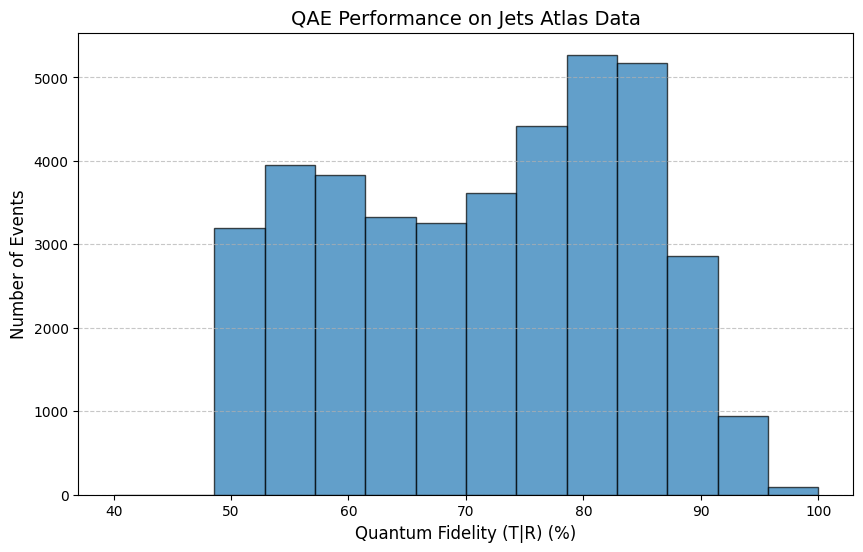

In [146]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

    num_layers = 5  # Número de capas variacionales
    theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    optimizer = torch.optim.Adam(
        [w, theta_i, phi_i, w_i],
        lr=0.01,              # Más típico y seguro
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=0.001,    # Regularización más suave
        amsgrad=True          # Empieza sin él
    )
    

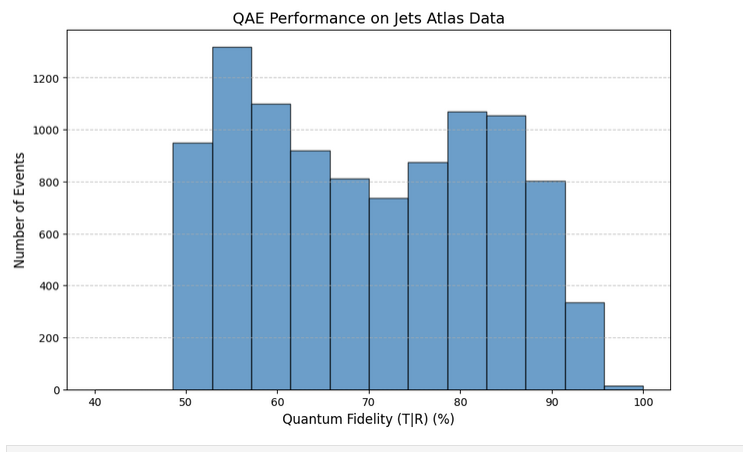


    w = torch.tensor(1.0, requires_grad=True)
    num_layers = 6  # Número de capas variacionales
    theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    optimizer = torch.optim.Adam(
        [w, theta_i, phi_i, w_i],
        lr=0.01,              # Más típico y seguro
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=0.01,    # Regularización más suave
        amsgrad=True          # Empieza sin él
    )
    
    num_epochs = 2

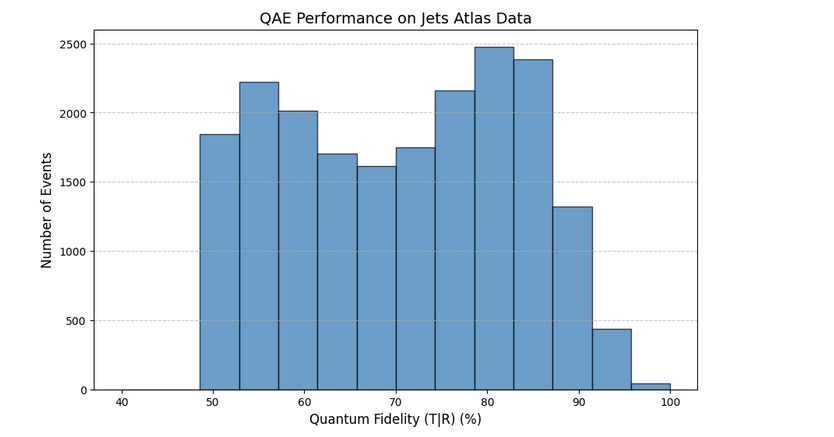


    w = torch.tensor(1.0, requires_grad=True)
    num_layers = 6  # Número de capas variacionales
    theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    optimizer = torch.optim.Adam(
        [w, theta_i, phi_i, w_i],
        lr=0.01,              # Más típico y seguro
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=0.01,    # Regularización más suave
        amsgrad=True          # Empieza sin él
    )
    
    num_epochs = 4
    all_fidelities = []
    event_fidelities = [] 





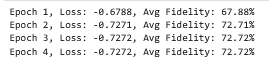

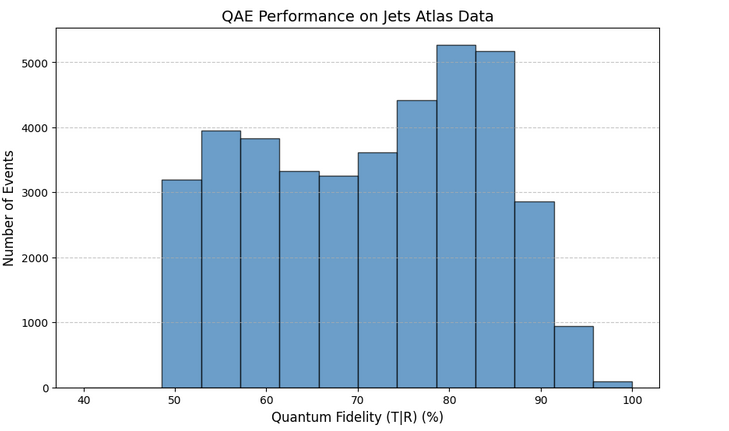

# Datasets utilizados 

**"Background"** : ATLAS_events_v0  (no me acuerda de que dataset venia) 

**"Exotic signal"** : https://opendata.cern.ch/record/80011 

**"Nominal Higgs"**  : https://opendata.cern.ch/record/80012  

In [175]:
from sklearn.metrics import roc_auc_score


w = torch.tensor(1.0, requires_grad=True)
num_layers = 6  # Número de capas variacionales
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,              # Más típico y seguro
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,    # Regularización más suave
    amsgrad=True          # Empieza sin él
)

num_epochs = 4
all_fidelities = []
event_fidelities = []  # Lista para almacenar fidelidades por evento

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    
    for evento in filtered_data_float_train:
        jets = evento['Jets'][:4]
        if len(jets) < 4:
            continue
            
        pt_jet, eta_jet, phi_jet = encontrar_maximos_per_jet(evento)
        loss, fidelity = cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # Convertir a porcentaje
    
    avg_loss = total_loss / len(filtered_data_float_train)
    avg_fidelity = np.mean(epoch_fidelities) * 100  # Convertir a porcentaje
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

#---- Test -----------------------
fidelities_100_back = []
fidelities_100_exotic = []
fidelities_100_higgs = []
fidelidades = []
etiquetas = []


# --- Background (clase 0) ---
for evento in filtered_data_float_test:
    jets = evento['Jets'][:4]
    if len(jets) < 4:
        continue
    pt_jet, eta_jet, phi_jet = encontrar_maximos_per_jet(evento)
    _, fidelity = cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers)
    fidelities_100_back.append(fidelity * 100)
    fidelidades.append(fidelity)
    etiquetas.append(0)
    
print("Terminado background")

# --- Exotic signal (clase 1) ---
for evento in filtered_data_exotic_test:
    jets = evento['Jets'][:4]
    if len(jets) < 4:
        continue
    pt_jet, eta_jet, phi_jet = encontrar_maximos_per_jet(evento)
    _, fidelity = cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers)
    fidelities_100_exotic.append(fidelity * 100)
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminado exotic")

# --- Nominal Higss (clase 2) ---
for evento in filtered_data_higgs_test:
    jets = evento['Jets'][:4]
    if len(jets) < 4:
        continue
    pt_jet, eta_jet, phi_jet = encontrar_maximos_per_jet(evento)
    _, fidelity = cost_function_with_fidelity(jets, w, theta_i, phi_i, w_i, pt_jet, eta_jet, phi_jet, num_layers)
    fidelities_100_higgs.append(fidelity * 100)
    fidelidades.append(fidelity)
    etiquetas.append(2)

print("Terminado nominal higs")

Epoch 1, Loss: -0.6854, Avg Fidelity: 68.54%
Epoch 2, Loss: -0.7271, Avg Fidelity: 72.71%
Epoch 3, Loss: -0.7271, Avg Fidelity: 72.71%
Epoch 4, Loss: -0.7271, Avg Fidelity: 72.71%
Terminado background
Terminado exotic
Terminado nominal higs


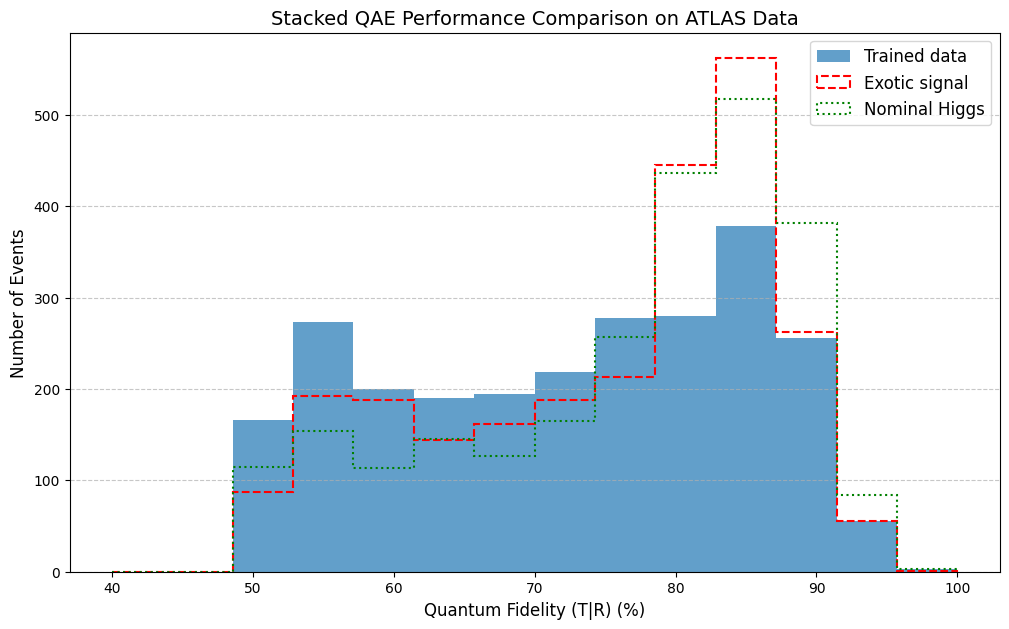

In [184]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(40, 100, 15)

plt.hist(fidelities_100_back, bins=np.linspace(40, 100, 15), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(fidelities_100_exotic, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='Exotic signal',
         histtype='step',  # Solo bordes
         stacked=True)

# 3. Higgs (solo bordes, sin relleno)
plt.hist(fidelities_100_higgs, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  
         linewidth=1.5,
         linestyle=':',     # Estilo de línea diferente
         label='Nominal Higgs',
         histtype='step', 
         stacked=True)



# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Stacked QAE Performance Comparison on ATLAS Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.savefig("qae_fidelity_stacked_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

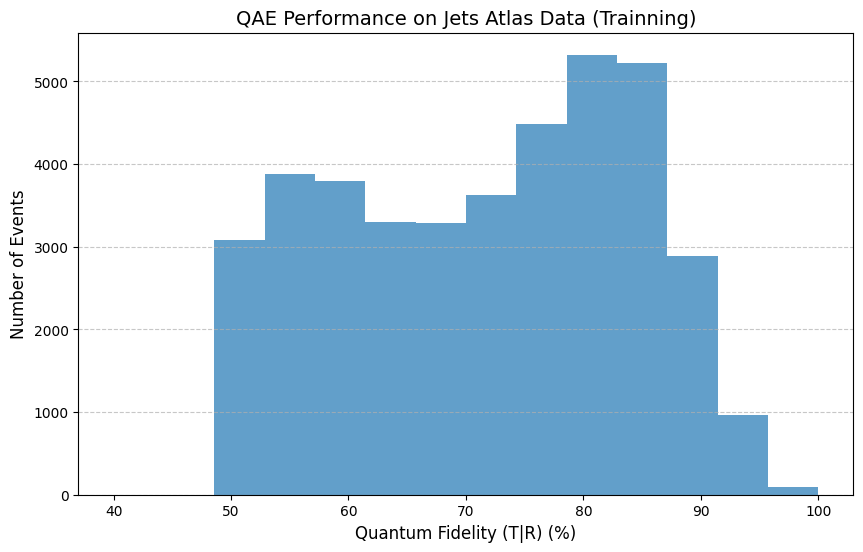

In [194]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data (Trainning)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [196]:
from sklearn.metrics import roc_auc_score
import numpy as np

etiquetas_np = np.array(etiquetas)
fidelidades_np = np.array(fidelidades)
mask = (etiquetas_np == 0) | (etiquetas_np == 1)
auc_binaria = roc_auc_score(etiquetas_np[mask], fidelidades_np[mask])
print(f"AUC (Trained vs exotic): {auc_binaria:.4f}")

mask = (etiquetas_np == 0) | (etiquetas_np == 2)
auc_binaria = roc_auc_score(etiquetas_np[mask], fidelidades_np[mask])
print(f"AUC (Trained vs nominal higgs): {auc_binaria:.4f}")


AUC (Trained vs exotic): 0.5648
AUC (Trained vs nominal higgs): 0.5997


---
Qutrits rotations

**Universality for Sets of Three-Valued Qubit Gates**
https://arxiv.org/pdf/2109.07282

**Majorana representation, qutrit Hilbert space and NMR implementation of qutrit
gates**
https://arxiv.org/pdf/1703.06102